In [14]:
from pathlib import Path
import pandas as pd
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [16]:
# ----------------------------------------------
# Paso 1: Cargar y revisar datos de jugador externo (Lamine Yamal)
# ----------------------------------------------

# Cargamos los archivos externos
future_logs = pd.read_csv("data/processed/future_stars_cleaned_matchlogs.csv")
future_meta = pd.read_csv("data/processed/future_stars_cleaned_metadata.csv")

# Mergeamos para obtener 'Birth_date'
future_df = future_logs.merge(
    future_meta[['Player_ID', 'Birth_date', 'Position']],
    on='Player_ID', how='left'
)

# Aseguramos formatos de fechas
future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')
future_df['Birth_date'] = pd.to_datetime(future_df['Birth_date'], errors='coerce')

# Calcular edad (como en pipeline original)
future_df['Age'] = (future_df['Date'] - future_df['Birth_date']).dt.days / 365.25

# Verificamos estructura
print("🔎 Datos de Lamine Yamal cargados:")
print(future_df[['Player_name', 'Date', 'Age', 'Minutes', 'Goals', 'Assists']].head())


🔎 Datos de Lamine Yamal cargados:
    Player_name       Date        Age Minutes Goals Assists
0   Player Name        NaT        NaN     Min   Gls     Ast
1  Lamine Yamal 2023-04-29  15.794661       8     0       0
2  Lamine Yamal 2023-09-08  16.156057      47     1       0
3  Lamine Yamal 2023-09-12  16.167009      60     0       0
4  Lamine Yamal 2023-11-16  16.344969      72     1       0


C:\Users\juanm\AppData\Local\Temp\ipykernel_19336\431134121.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  future_df['Date'] = pd.to_datetime(future_df['Date'], errors='coerce')


In [17]:
# ----------------------------------------------
# Paso 2: Calcular rating_per_90 como en el modelo original
# ----------------------------------------------

# 1. Aseguramos que no haya nulos y que sean numéricos
rating_cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
for col in rating_cols:
    future_df[col] = pd.to_numeric(future_df[col], errors='coerce').fillna(0)

# Definimos la función
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

# 2. Aplicamos la fórmula
future_df['rating_per_90'] = future_df.apply(calculate_rating, axis=1)

# 3. Mostramos resultado
print("\n🎯 Ejemplo de rating_per_90 calculado por partido:")
print(future_df[['Date', 'Minutes', 'Goals', 'Assists', 'rating_per_90']].head())



🎯 Ejemplo de rating_per_90 calculado por partido:
        Date  Minutes  Goals  Assists  rating_per_90
0        NaT      0.0    0.0      0.0       0.000000
1 2023-04-29      8.0    0.0      0.0       5.625000
2 2023-09-08     47.0    1.0      0.0      10.914894
3 2023-09-12     60.0    0.0      0.0       1.650000
4 2023-11-16     72.0    1.0      0.0       6.875000


In [18]:
# ----------------------------------------------
# Paso 3: Agregación por año natural y creación de perfil anual
# ----------------------------------------------

# 1. Extraemos el año natural (para seguir lógica del modelo)
future_df['Natural_year'] = future_df['Date'].dt.year

# 2. Detectamos el año de debut de Lamine (el más temprano con minutos > 0)
debut_year = future_df[future_df['Minutes'] > 0]['Natural_year'].min()

# 3. Creamos 'year_since_debut' como en el modelo
future_df['year_since_debut'] = future_df['Natural_year'] - debut_year + 1

# 4. Agregamos como hicimos en career_df
lamine_season = future_df.groupby('year_since_debut').agg({
    'rating_per_90': 'mean',
    'Age': 'mean',
    'Minutes': 'sum'
}).reset_index()

# 5. Pivot para convertir a columnas por año (1, 2, 3…)
pivot_rating = lamine_season.pivot(columns='year_since_debut', values='rating_per_90')
pivot_age = lamine_season.pivot(columns='year_since_debut', values='Age')
pivot_minutes = lamine_season.pivot(columns='year_since_debut', values='Minutes')

# 6. Renombramos las columnas para que coincidan con el modelo
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 7. Unimos todo en un solo DataFrame para el modelo
lamine_model = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# 8. Calculamos features derivadas igual que hicimos para los demás
if 'rating_year_2' in lamine_model.columns and 'rating_year_1' in lamine_model.columns:
    lamine_model['growth_2_1'] = lamine_model['rating_year_2'] - lamine_model['rating_year_1']
if 'rating_year_3' in lamine_model.columns and 'rating_year_2' in lamine_model.columns:
    lamine_model['growth_3_2'] = lamine_model['rating_year_3'] - lamine_model['rating_year_2']

lamine_model['avg_rating'] = lamine_model[[col for col in lamine_model.columns if 'rating_year_' in col]].mean(axis=1)
lamine_model['sum_minutes'] = lamine_model[[col for col in lamine_model.columns if 'minutes_year_' in col]].sum(axis=1)

# Tendencias si existen
if 'rating_year_3' in lamine_model.columns and 'rating_year_1' in lamine_model.columns:
    lamine_model['rating_trend'] = lamine_model['rating_year_3'] - lamine_model['rating_year_1']
if 'minutes_year_3' in lamine_model.columns and 'minutes_year_1' in lamine_model.columns:
    lamine_model['minutes_trend'] = lamine_model['minutes_year_3'] - lamine_model['minutes_year_1']

# 9. Verificamos el perfil generado
print("\n🧠 Perfil anual de Lamine Yamal para el modelo:")
display(lamine_model.T)



🧠 Perfil anual de Lamine Yamal para el modelo:


,0,1,2
rating_year_1.0,1.595697,NaN,NaN
rating_year_2.0,NaN,3.685902,NaN
rating_year_3.0,NaN,NaN,4.213712
age_year_1.0,16.254148,NaN,NaN
age_year_2.0,NaN,16.940315,NaN
age_year_3.0,NaN,NaN,17.663701
minutes_year_1.0,1311.000000,NaN,NaN
minutes_year_2.0,NaN,4461.000000,NaN
minutes_year_3.0,NaN,NaN,2757.000000
avg_rating,1.595697,3.685902,4.213712


In [22]:
import joblib

# 1. Cargar modelo entrenado
model = joblib.load('model/futpeak_model_multi.joblib')

# 2. Cargar LabelEncoder
le = joblib.load('model/label_encoder.joblib')

# 3. Cargar curvas promedio por grupo
df_curves = joblib.load('model/curvas_promedio.joblib')

# 4. Cargar columnas del modelo (orden correcto)
model_features = joblib.load('model/model_features.joblib')



In [23]:
# ----------------------------------------------
# Paso 4: Predicción de grupo con modelo entrenado
# ----------------------------------------------

# 1. Aseguramos que las columnas estén en el mismo orden que las del modelo
X_columns = rf_model.feature_names_in_  # columnas originales del modelo
lamine_input = lamine_model.reindex(columns=X_columns, fill_value=0)

# 2. Hacemos la predicción
lamine_pred_encoded = rf_model.predict(lamine_input)[0]
lamine_pred = label_encoder.inverse_transform([lamine_pred_encoded])[0]

# 3. Mostramos el resultado
print(f"\n🎯 Predicción del modelo para Lamine Yamal:")
print(f"🧠 Grupo estimado: {lamine_pred}")



🎯 Predicción del modelo para Lamine Yamal:
🧠 Grupo estimado: joven estrella


C:\Users\juanm\AppData\Local\Temp\ipykernel_19336\1722309496.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


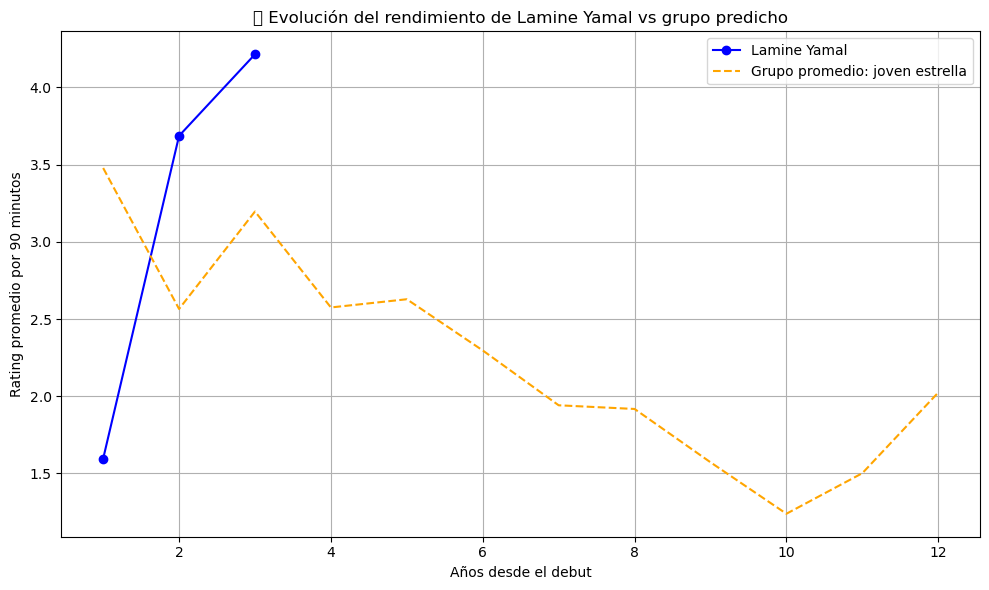

In [25]:
import matplotlib.pyplot as plt


# Aseguramos que tenga la columna Natural_year
future_df['Natural_year'] = future_df['Date'].dt.year

# Detectar año de debut (primer año con minutos > 0)
debut_year = future_df[future_df['Minutes'] > 0]['Natural_year'].min()

# Calcular años desde el debut
future_df['year_since_debut'] = future_df['Natural_year'] - debut_year + 1

# Agregamos como en career_df
lamine_seasonal = future_df.groupby('year_since_debut').agg({
    'Minutes': 'sum',
    'rating_per_90': 'mean'
}).reset_index()

# Obtener la curva promedio del grupo predicho
group_curve = df_curves[df_curves['peak_group'] == lamine_pred]

# Graficar
plt.figure(figsize=(10, 6))

# Curva del jugador
plt.plot(
    lamine_seasonal['year_since_debut'],
    lamine_seasonal['rating_per_90'],
    marker='o', linestyle='-', label='Lamine Yamal', color='blue'
)

# Curva promedio del grupo
plt.plot(
    group_curve['year_since_debut'],
    group_curve['rating_avg'],
    linestyle='--', color='orange', label=f'Grupo promedio: {lamine_pred}'
)

# Etiquetas y detalles
plt.title("📈 Evolución del rendimiento de Lamine Yamal vs grupo predicho")
plt.xlabel("Años desde el debut")
plt.ylabel("Rating promedio por 90 minutos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\juanm\AppData\Local\Temp\ipykernel_19336\3434799055.py:53: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


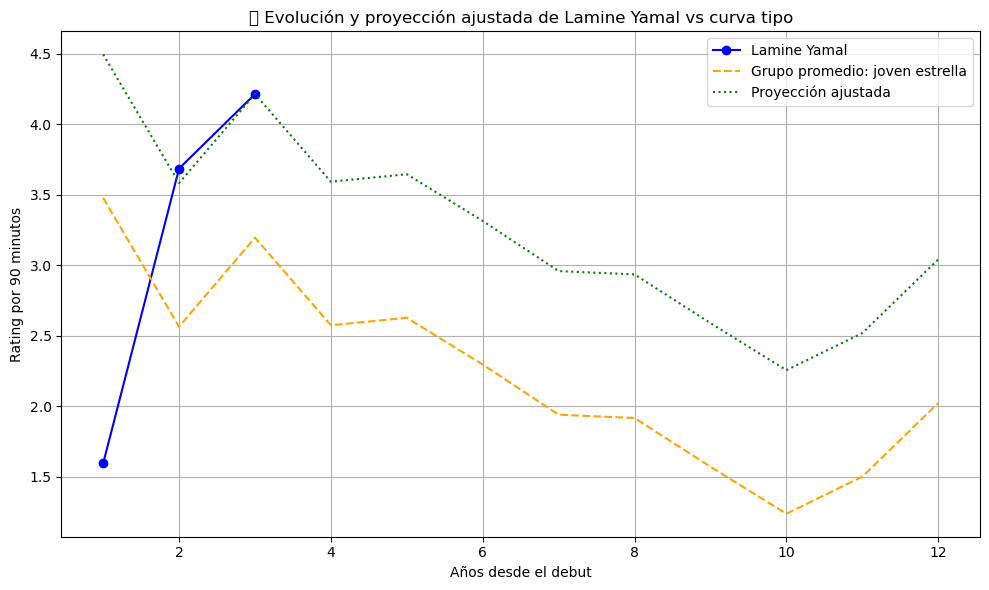

In [27]:
import matplotlib.pyplot as plt
import joblib

# Cargar curva promedio
df_curves = joblib.load("model/curvas_promedio.joblib")

# 1. Obtener la curva del grupo predicho
group_curve = df_curves[df_curves['peak_group'] == lamine_pred].copy()

# 2. Detectar último año observado de Lamine
last_real_year = lamine_seasonal['year_since_debut'].max()
last_real_rating = lamine_seasonal.loc[lamine_seasonal['year_since_debut'] == last_real_year, 'rating_per_90'].values[0]

# 3. Obtener valor del grupo promedio en ese mismo año
reference_group_value = group_curve.loc[group_curve['year_since_debut'] == last_real_year, 'rating_avg'].values[0]

# 4. Calcular el desplazamiento necesario
shift = last_real_rating - reference_group_value

# 5. Ajustar la curva tipo para proyectar la de Lamine
group_curve['projection'] = group_curve['rating_avg'] + shift

# 6. Gráfico comparativo
plt.figure(figsize=(10, 6))

# Curva real de Lamine
plt.plot(
    lamine_seasonal['year_since_debut'],
    lamine_seasonal['rating_per_90'],
    marker='o', linestyle='-', color='blue', label='Lamine Yamal'
)

# Curva promedio del grupo
plt.plot(
    group_curve['year_since_debut'],
    group_curve['rating_avg'],
    linestyle='--', color='orange', label=f'Grupo promedio: {lamine_pred}'
)

# Proyección ajustada
plt.plot(
    group_curve['year_since_debut'],
    group_curve['projection'],
    linestyle=':', color='green', label='Proyección ajustada'
)

# Detalles
plt.title("📈 Evolución y proyección ajustada de Lamine Yamal vs curva tipo")
plt.xlabel("Años desde el debut")
plt.ylabel("Rating por 90 minutos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
import matplotlib.pyplot as plt

# ----------------------------------------------
# 📌 Parámetros del jugador
# ----------------------------------------------
lamine_id = 'b19db005'  # ID de Lamine Yamal (ajústalo si cambias jugador)

# ----------------------------------------------
# 🧼 Aseguramos tipos correctos
# ----------------------------------------------
future_df['Minutes'] = pd.to_numeric(future_df['Minutes'], errors='coerce')
future_df['Natural_year'] = pd.to_numeric(future_df['Natural_year'], errors='coerce')

# ----------------------------------------------
# 📦 Extraemos partidos del jugador
# ----------------------------------------------
lamine_df = future_df[future_df['Player_ID'] == lamine_id].copy()

print("\n📋 Primeros partidos encontrados para el jugador:")
print(lamine_df[['Natural_year', 'Minutes', 'rating_per_90']].head())

# Filtramos partidos con minutos > 0
lamine_df = lamine_df[lamine_df['Minutes'] > 0]

if lamine_df.empty:
    print("❌ No se encontraron partidos con minutos > 0 para este jugador.")
else:
    # ----------------------------------------------
    # 🧮 Trayectoria anual
    # ----------------------------------------------
    lamine_debut_year = lamine_df['Natural_year'].min()
    lamine_df['year_since_debut'] = lamine_df['Natural_year'] - lamine_debut_year + 1

    lamine_seasonal = lamine_df.groupby('year_since_debut').agg({
        'Minutes': 'sum',
        'rating_per_90': 'mean'
    }).reset_index()

    print("\n✅ Trayectoria agregada por año:")
    print(lamine_seasonal)

    # ----------------------------------------------
    # 🔁 Ajuste de curva tipo
    # ----------------------------------------------
    group_curve = df_curves[df_curves['peak_group'] == lamine_pred].copy()

    lamine_mean = lamine_seasonal[lamine_seasonal['year_since_debut'] <= 3]['rating_per_90'].mean()
    group_mean = group_curve[group_curve['year_since_debut'] <= 3]['rating_avg'].mean()
    adjustment = lamine_mean - group_mean
    group_curve['rating_adjusted'] = group_curve['rating_avg'] + adjustment

    # ----------------------------------------------
    # 📈 Visualización
    # ----------------------------------------------
    plt.figure(figsize=(10, 6))

    # Curva real de Lamine
    plt.plot(
        lamine_seasonal['year_since_debut'],
        lamine_seasonal['rating_per_90'],
        marker='o', linestyle='-', color='blue',
        label='Lamine Yamal'
    )

    # Curva promedio del grupo
    plt.plot(
        group_curve['year_since_debut'],
        group_curve['rating_avg'],
        linestyle='--', color='orange',
        label=f'Grupo promedio: {lamine_pred}'
    )

    # Proyección ajustada
    plt.plot(
        group_curve['year_since_debut'],
        group_curve['rating_adjusted'],
        linestyle=':', color='green',
        label='Proyección ajustada'
    )

    plt.title("📈 Evolución y proyección ajustada de Lamine Yamal vs curva tipo")
    plt.xlabel("Años desde el debut")
    plt.ylabel("Rating por 90 minutos")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




📋 Primeros partidos encontrados para el jugador:
Empty DataFrame
Columns: [Natural_year, Minutes, rating_per_90]
Index: []
❌ No se encontraron partidos con minutos > 0 para este jugador.
